In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
import seaborn as sns
import random

seed=11
seq_length = 30
stock ='PEP'

# Main functions

In [91]:
def prepare_df(features):
  news = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_news_sentiment.csv', index_col=0).sort_values('date').set_index('date')
  sp = pd.read_csv('/content/drive/MyDrive/Team_Daccord/data/SP500.csv')
  sp['Date'] = pd.to_datetime(sp['Date'], format="%m/%d/%y")
  sp = sp.sort_values('Date').set_index('Date')
  sp.columns = ['sp_Open', 'sp_High', 'sp_Low', 'sp_Close'] 
  fin = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_financial.csv', index_col=0)
  a = pd.DataFrame(pd.date_range(start='2009-10-01', end='2021-07-01').strftime("%Y-%m-%d"), columns=['Date']).merge(fin, left_on='Date', right_on='date', how='left').fillna(method='pad')
  b = pd.to_datetime(a['Date'],format="%Y-%m-%d")
  c = pd.to_datetime(a['date'],format="%Y-%m-%d")
  a['day_delta'] = (b - c).apply(lambda x: x.days).values
  a = a.set_index('Date')
  df = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_historical.csv',index_col=0).sort_values('date').set_index('date')
  df = sp.join(df, how='left').join(news, how='left').join(a[list(fin.columns)+['day_delta']], how='left')
  df = df.fillna(0)

  df = df[df.index > '2013-01-01']
  dates = df.index[seq_length:].strftime('%Y-%m-%d')
  res = {}
  if features['seq']:
    data_seq = df.loc[:, features['seq']].to_numpy()
    res['seq'] = data_seq
  if features['tmp']:
    data_tmp = df.loc[:, features['tmp']].to_numpy()
    res['tmp'] = data_tmp
  if features['tmp2']:
    data_tmp2 = df.loc[:, features['tmp2']].to_numpy()
    res['tmp2'] = data_tmp2
  data_y = df.loc[:,['adjClose']].to_numpy()
  
  return res, data_y, dates

def prepare_data():
  def sliding_windows(data_seq, seq_length):
      x = []
      for i in range(len(data_seq)-seq_length):
          _x = data_seq[i:(i+seq_length)]
          x.append(_x)
      return np.array(x)

  sc_y = MinMaxScaler()
  y = sc_y.fit_transform(data_y)[seq_length:].reshape(-1, 1)
  train_size = int(len(y) * 0.90)
  test_size = len(y) - train_size
  dataY = Variable(torch.Tensor(np.array(y)))
  trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
  testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

  trainX = {}
  testX = {}
  if features['seq']:
    sc_seq = MinMaxScaler()
    x_seq = sliding_windows(sc_seq.fit_transform(res['seq']), seq_length)
    dataX_seq = Variable(torch.Tensor(np.array(x_seq)))
    trainX_seq = Variable(torch.Tensor(np.array(x_seq[0:train_size])))
    trainX['seq'] = trainX_seq
    testX_seq = Variable(torch.Tensor(np.array(x_seq[train_size:len(x_seq)])))
    testX['seq'] = testX_seq
  if features['tmp']:
    sc_tmp = MinMaxScaler()
    x_tmp = sc_tmp.fit_transform(res['tmp'])[seq_length:]
    dataX_tmp = Variable(torch.Tensor(np.array(x_tmp)))
    trainX_tmp = Variable(torch.Tensor(np.array(x_tmp[0:train_size])))
    trainX['tmp'] = trainX_tmp
    testX_tmp = Variable(torch.Tensor(np.array(x_tmp[train_size:len(x_tmp)])))
    testX['tmp'] = testX_tmp
  if features['tmp2']:
    sc_tmp2 = MinMaxScaler()
    x_tmp2 = sc_tmp2.fit_transform(res['tmp2'])[seq_length:]
    dataX_tmp2 = Variable(torch.Tensor(np.array(x_tmp2)))
    trainX_tmp2 = Variable(torch.Tensor(np.array(x_tmp2[0:train_size])))
    trainX['tmp2'] = trainX_tmp2
    testX_tmp2 = Variable(torch.Tensor(np.array(x_tmp2[train_size:len(x_tmp2)])))
    testX['tmp2'] = testX_tmp2

  return trainX, testX, trainY, testY, sc_y, train_size


class system(nn.Module):

    def __init__(self, num_classes, hidden_size, num_layers,
                 up_input_size, down_input_size, down2_input_size):
        super(system, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.up_input_size = up_input_size 
        self.up = nn.LSTM(input_size=up_input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.down_input_size = down_input_size
        self.down = torch.nn.Sequential(
                              torch.nn.Linear(down_input_size, 10),
                              torch.nn.Sigmoid(),
                              torch.nn.Linear(10, 3),
                              torch.nn.Tanh()
                          )
        self.down2_input_size = down2_input_size
        self.down2 = torch.nn.Sequential(
                              torch.nn.Linear(down2_input_size, 6),
                              torch.nn.Sigmoid(),
                              torch.nn.Linear(6, 3),
                              torch.nn.Tanh()
                          )
        self.final = torch.nn.Sequential(
                              torch.nn.Linear((up_input_size!=0)*1+(down_input_size!=0)*3+(down2_input_size!=0)*3, 1)
                          )
        
        self.fc = nn.Linear(hidden_size*num_layers, num_classes)

    def forward(self, trainX):
        out_lst = []
        if self.up_input_size!=0:
          x_seq = trainX['seq']
          h_0 = Variable(torch.zeros(
              self.num_layers, x_seq.size(0), self.hidden_size))
          c_0 = Variable(torch.zeros(
              self.num_layers, x_seq.size(0), self.hidden_size))
          # Propagate input through LSTM
          ula, (h_out, _) = self.up(x_seq, (h_0, c_0))
          # if multiple layers
          h_out = torch.cat((h_out[0], h_out[1]), 1)
          up_out = self.fc(h_out)
          out_lst.append(up_out)
        if self.down_input_size!=0:
          x_tmp = trainX['tmp']
          down_out = self.down(x_tmp)
          out_lst.append(down_out)
        if self.down2_input_size!=0:
          x_tmp2 = trainX['tmp2']
          down2_out = self.down2(x_tmp2)
          out_lst.append(down2_out)
        
        out = self.final(torch.cat(out_lst,1))

        return out


def run():
  num_epochs = 2000
  learning_rate = 0.01
  if features['seq']:
    up_input_size = trainX['seq'].shape[2]
  else:
    up_input_size = 0
  if features['tmp']:
    down_input_size = trainX['tmp'].shape[1]
  else:
    down_input_size = 0
  if features['tmp2']:
    down2_input_size = trainX['tmp2'].shape[1]
  else:
    down2_input_size = 0  

  hidden_size = 5
  num_layers = 2
  num_classes = 1

  model = system(num_classes, hidden_size, num_layers,
                 up_input_size, down_input_size, down2_input_size)
  
  criterion = torch.nn.MSELoss()    # mean-squared error for regression
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

  # Train the model
  for epoch in range(num_epochs):
      outputs = model(trainX)

      optimizer.zero_grad()
      
      # obtain the loss function
      loss = criterion(outputs, trainY)
      
      loss.backward()
      
      optimizer.step()
      if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
  return model

def plot():
  model.eval()
  all = {}
  for i in trainX.keys():
    all[i] = torch.cat((trainX[i], testX[i]))
  
  train_predict = model(all)
  data_predict = train_predict.data.numpy()
  dataY_plot = torch.cat((trainY, testY)).data.numpy()

  data_predict = sc_y.inverse_transform(data_predict)
  dataY_plot = sc_y.inverse_transform(dataY_plot.reshape(-1, 1))

  plt.figure(figsize=(20,8))
  plt.axvline(x=train_size, c='r', linestyle='--')

  plt.plot(dataY_plot)
  plt.plot(data_predict)
  plt.xticks(range(0, len(dataY_plot), 180), dates[::180])
  plt.suptitle('Time-Series Prediction')
  plt.show()

  print(MSE(dataY_plot, data_predict))
  pd.DataFrame(np.concatenate([dataY_plot, data_predict],axis=1), index=dates, columns=['Actual', 'Predicted']).to_csv(f'{path}{name}.csv')

# Hypo 1

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.05139
Epoch: 100, loss: 0.00487
Epoch: 200, loss: 0.00462
Epoch: 300, loss: 0.00438
Epoch: 400, loss: 0.00346
Epoch: 500, loss: 0.00332
Epoch: 600, loss: 0.00318
Epoch: 700, loss: 0.00304
Epoch: 800, loss: 0.00291
Epoch: 900, loss: 0.00279
Epoch: 1000, loss: 0.00275
Epoch: 1100, loss: 0.00270
Epoch: 1200, loss: 0.00271
Epoch: 1300, loss: 0.00272
Epoch: 1400, loss: 0.00379
Epoch: 1500, loss: 0.00257
Epoch: 1600, loss: 0.00249
Epoch: 1700, loss: 0.00246
Epoch: 1800, loss: 0.00280
Epoch: 1900, loss: 0.00406


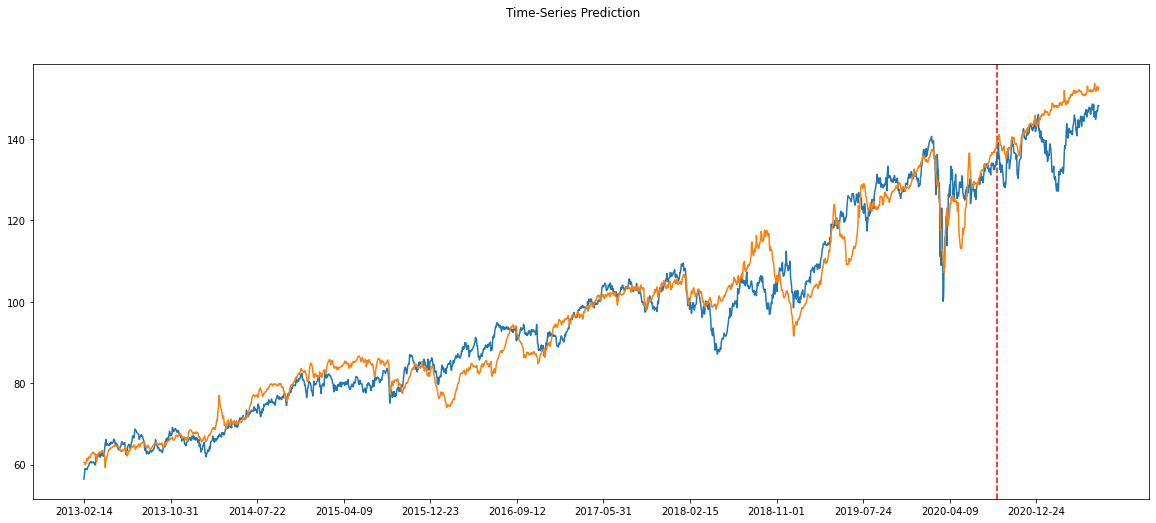

26.735851


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.05727
Epoch: 100, loss: 0.01202
Epoch: 200, loss: 0.00955
Epoch: 300, loss: 0.00892
Epoch: 400, loss: 0.00776
Epoch: 500, loss: 0.00741
Epoch: 600, loss: 0.00798
Epoch: 700, loss: 0.00667
Epoch: 800, loss: 0.00652
Epoch: 900, loss: 0.00622
Epoch: 1000, loss: 0.00577
Epoch: 1100, loss: 0.00543
Epoch: 1200, loss: 0.00526
Epoch: 1300, loss: 0.00895
Epoch: 1400, loss: 0.00623
Epoch: 1500, loss: 0.00509
Epoch: 1600, loss: 0.00591
Epoch: 1700, loss: 0.00552
Epoch: 1800, loss: 0.00469
Epoch: 1900, loss: 0.00473


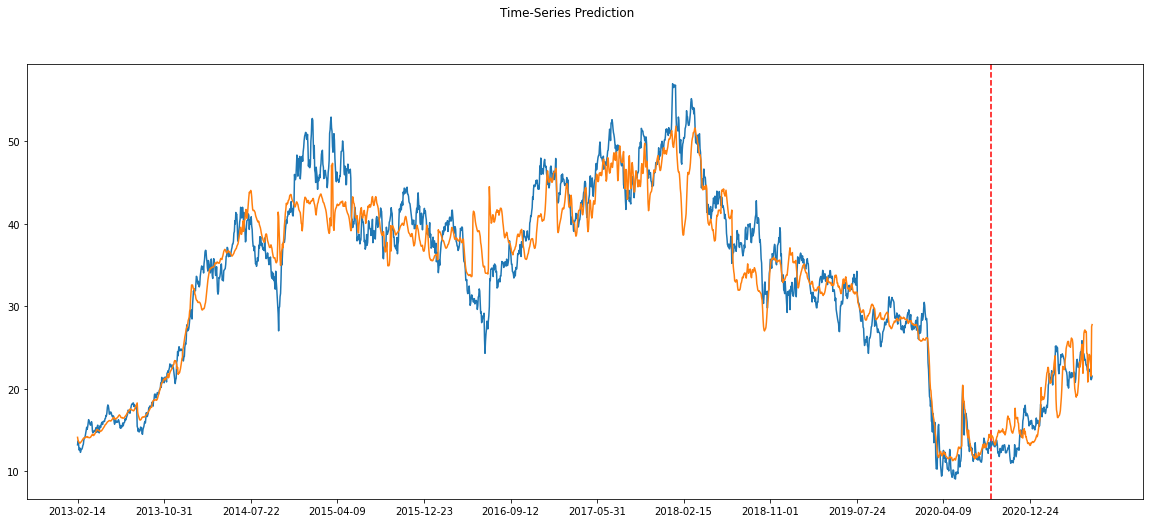

11.183472


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.03925
Epoch: 100, loss: 0.00391
Epoch: 200, loss: 0.00350
Epoch: 300, loss: 0.00264
Epoch: 400, loss: 0.00223
Epoch: 500, loss: 0.00222
Epoch: 600, loss: 0.00197
Epoch: 700, loss: 0.00179
Epoch: 800, loss: 0.00179
Epoch: 900, loss: 0.00149
Epoch: 1000, loss: 0.00126
Epoch: 1100, loss: 0.00118
Epoch: 1200, loss: 0.00110
Epoch: 1300, loss: 0.00105
Epoch: 1400, loss: 0.00101
Epoch: 1500, loss: 0.00094
Epoch: 1600, loss: 0.00084
Epoch: 1700, loss: 0.00076
Epoch: 1800, loss: 0.00075
Epoch: 1900, loss: 0.00071


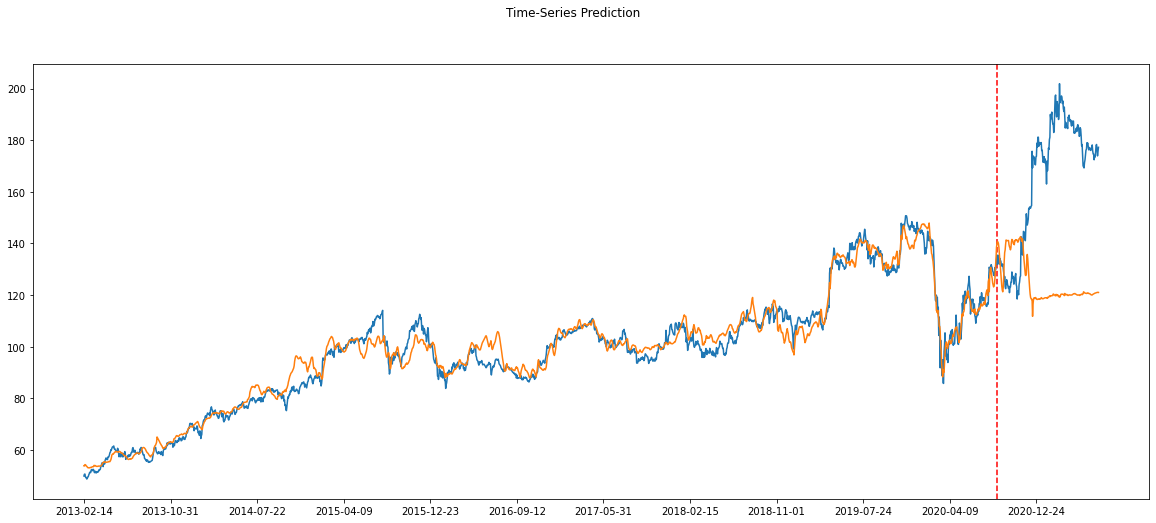

278.3487


In [92]:
for stock in ['PEP', 'AAL', 'DIS']:
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
  np.random.seed(seed)  # Numpy module.
  random.seed(seed)  # Python random module.
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

  features = {
      'seq':  ['volume', 'sp_Close'],
      'tmp': [],
      'tmp2': []
  }

  path = '/content/drive/MyDrive/Team_Daccord/ouput/hypo1/'
  name = f'{stock}_hypo1'
  res, data_y, dates = prepare_df(features)
  trainX, testX, trainY, testY, sc_y, train_size = prepare_data()
  model = run()
  plot()

# Hypo 2

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.12891
Epoch: 100, loss: 0.00897
Epoch: 200, loss: 0.00368
Epoch: 400, loss: 0.00310
Epoch: 500, loss: 0.00302
Epoch: 600, loss: 0.00293
Epoch: 700, loss: 0.00276
Epoch: 800, loss: 0.00269
Epoch: 900, loss: 0.00257
Epoch: 1000, loss: 0.00324
Epoch: 1100, loss: 0.00242
Epoch: 1200, loss: 0.00239
Epoch: 1300, loss: 0.00239
Epoch: 1400, loss: 0.00299
Epoch: 1500, loss: 0.00220
Epoch: 1600, loss: 0.00196
Epoch: 1700, loss: 0.00188
Epoch: 1800, loss: 0.00212
Epoch: 1900, loss: 0.00170


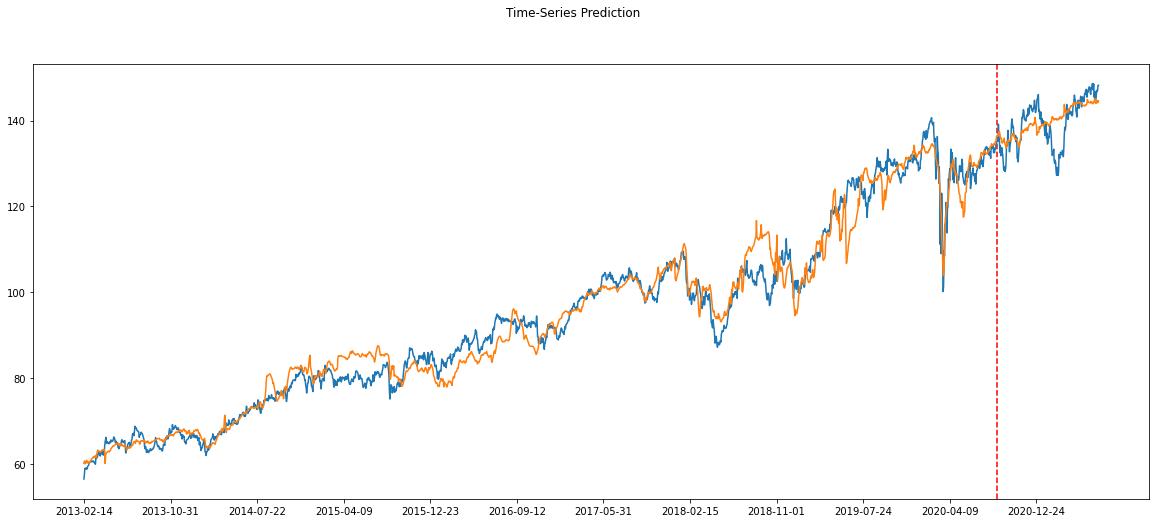

15.094918


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.21250
Epoch: 100, loss: 0.05177
Epoch: 200, loss: 0.02922
Epoch: 300, loss: 0.00865
Epoch: 400, loss: 0.00726
Epoch: 500, loss: 0.00712
Epoch: 600, loss: 0.00656
Epoch: 700, loss: 0.00598
Epoch: 800, loss: 0.00599
Epoch: 900, loss: 0.00904
Epoch: 1000, loss: 0.00542
Epoch: 1100, loss: 0.00566
Epoch: 1200, loss: 0.00508
Epoch: 1300, loss: 0.00536
Epoch: 1400, loss: 0.00485
Epoch: 1500, loss: 0.00481
Epoch: 1600, loss: 0.00488
Epoch: 1700, loss: 0.00444
Epoch: 1800, loss: 0.00446
Epoch: 1900, loss: 0.00448


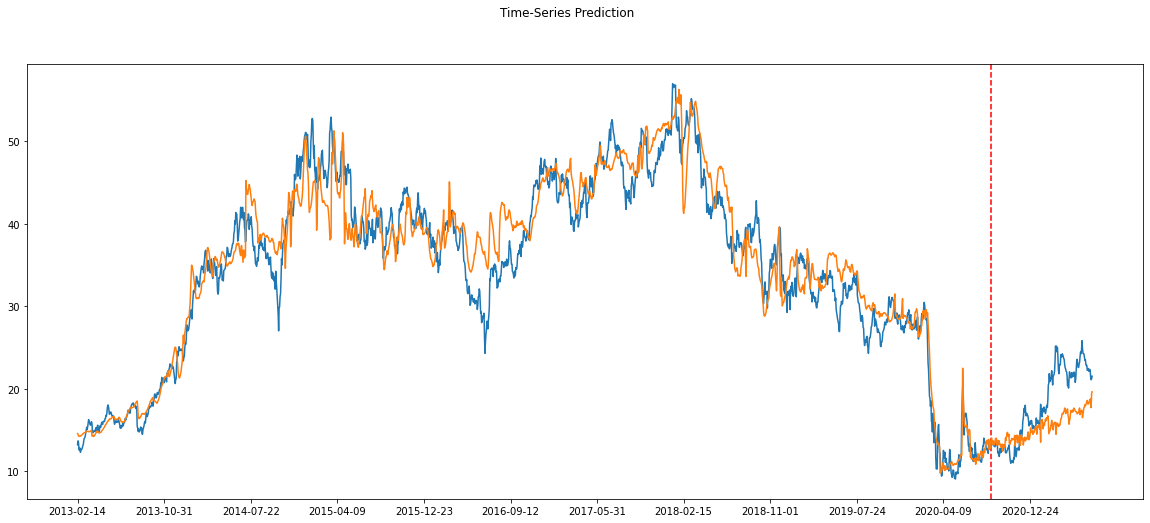

10.60543


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.05968
Epoch: 100, loss: 0.00365
Epoch: 200, loss: 0.00206
Epoch: 300, loss: 0.00183
Epoch: 400, loss: 0.00163
Epoch: 500, loss: 0.00153
Epoch: 600, loss: 0.00148
Epoch: 700, loss: 0.00162
Epoch: 800, loss: 0.00135
Epoch: 900, loss: 0.00121
Epoch: 1000, loss: 0.00122
Epoch: 1100, loss: 0.00115
Epoch: 1200, loss: 0.00106
Epoch: 1300, loss: 0.00115
Epoch: 1400, loss: 0.00100
Epoch: 1500, loss: 0.00096
Epoch: 1600, loss: 0.00096
Epoch: 1700, loss: 0.00094
Epoch: 1800, loss: 0.00092
Epoch: 1900, loss: 0.00091


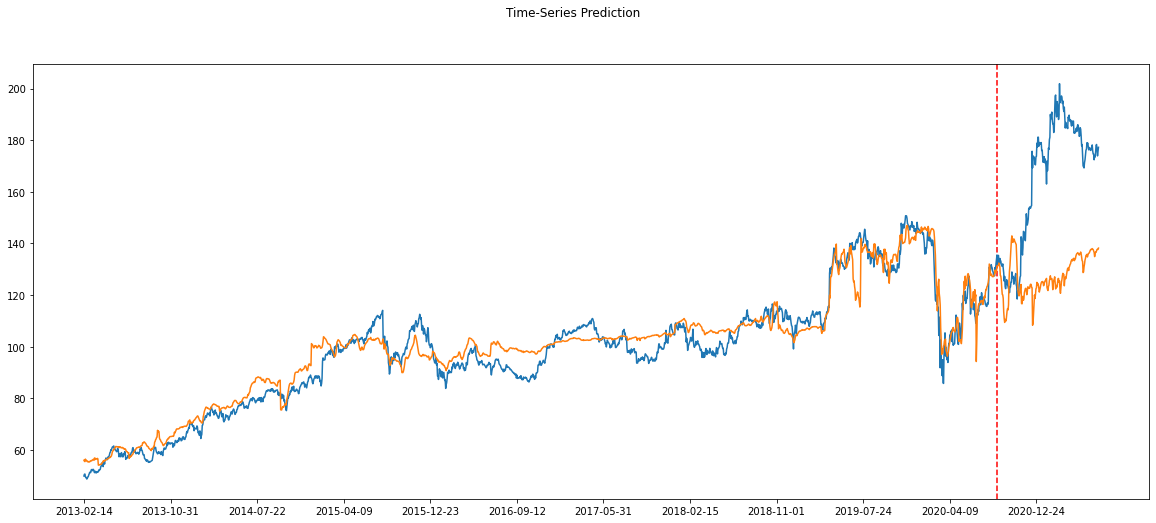

225.74214


In [96]:
for stock in ['PEP', 'AAL', 'DIS']:
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
  np.random.seed(seed)  # Numpy module.
  random.seed(seed)  # Python random module.
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

  sentiments = [
              'pos',
            'neg', 
            'pos - neg', 
            'nrc anger',
            'nrc anticipation', 'nrc disgust', 'nrc fear', 'nrc joy', 'nrc neg',
            'nrc pos', 'nrc sadness', 'nrc surprise', 'nrc trust'
            ]


  features = {
      'seq':  ['volume', 'sp_Close'],
      'tmp': [],
      'tmp2': ['revenue', 'grossProfit', 'netIncome', 'day_delta']
  }

  path = '/content/drive/MyDrive/Team_Daccord/ouput/hypo2/'
  name = f'{stock}_hypo2'
  res, data_y, dates = prepare_df(features)
  trainX, testX, trainY, testY, sc_y, train_size = prepare_data()
  model = run()
  plot()

# Hypo3

Epoch: 0, loss: 0.24525
Epoch: 100, loss: 0.00508
Epoch: 200, loss: 0.00382
Epoch: 300, loss: 0.00346
Epoch: 400, loss: 0.00307
Epoch: 500, loss: 0.00273
Epoch: 600, loss: 0.00283
Epoch: 700, loss: 0.00252
Epoch: 800, loss: 0.00259
Epoch: 900, loss: 0.00248
Epoch: 1000, loss: 0.00259
Epoch: 1100, loss: 0.00247
Epoch: 1200, loss: 0.00246
Epoch: 1300, loss: 0.00240
Epoch: 1400, loss: 0.00242
Epoch: 1500, loss: 0.00279
Epoch: 1600, loss: 0.00232
Epoch: 1700, loss: 0.00244
Epoch: 1800, loss: 0.00251
Epoch: 1900, loss: 0.00218


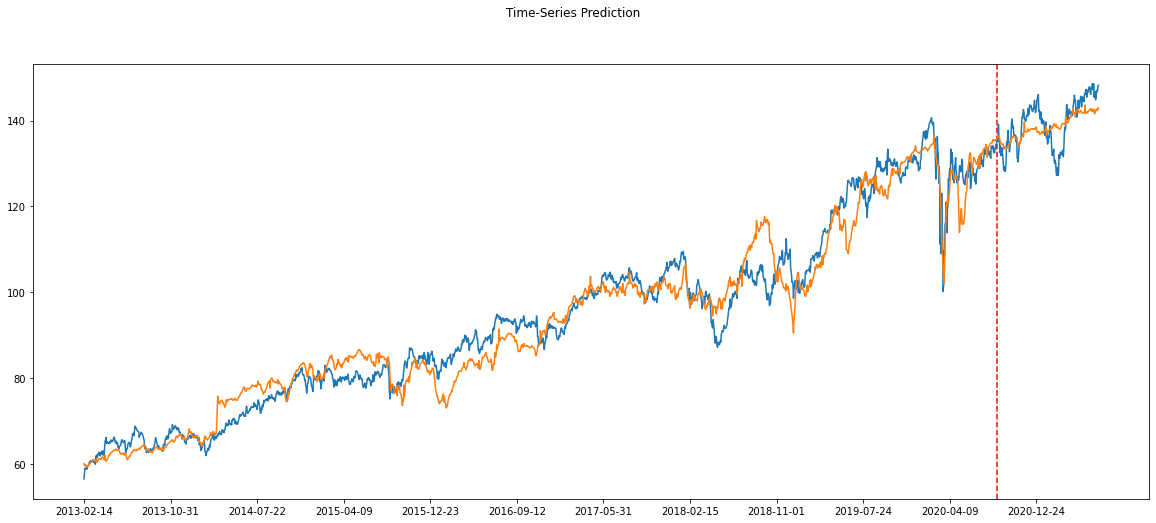

21.277596
Epoch: 0, loss: 0.37104
Epoch: 100, loss: 0.05059
Epoch: 200, loss: 0.03899
Epoch: 300, loss: 0.02327
Epoch: 400, loss: 0.01783
Epoch: 500, loss: 0.01225
Epoch: 600, loss: 0.00927
Epoch: 700, loss: 0.00849
Epoch: 800, loss: 0.00782
Epoch: 900, loss: 0.00727
Epoch: 1000, loss: 0.00692
Epoch: 1100, loss: 0.00649
Epoch: 1200, loss: 0.00637
Epoch: 1300, loss: 0.00606
Epoch: 1400, loss: 0.00591
Epoch: 1500, loss: 0.00638
Epoch: 1600, loss: 0.00573
Epoch: 1700, loss: 0.00553
Epoch: 1800, loss: 0.00645
Epoch: 1900, loss: 0.00515


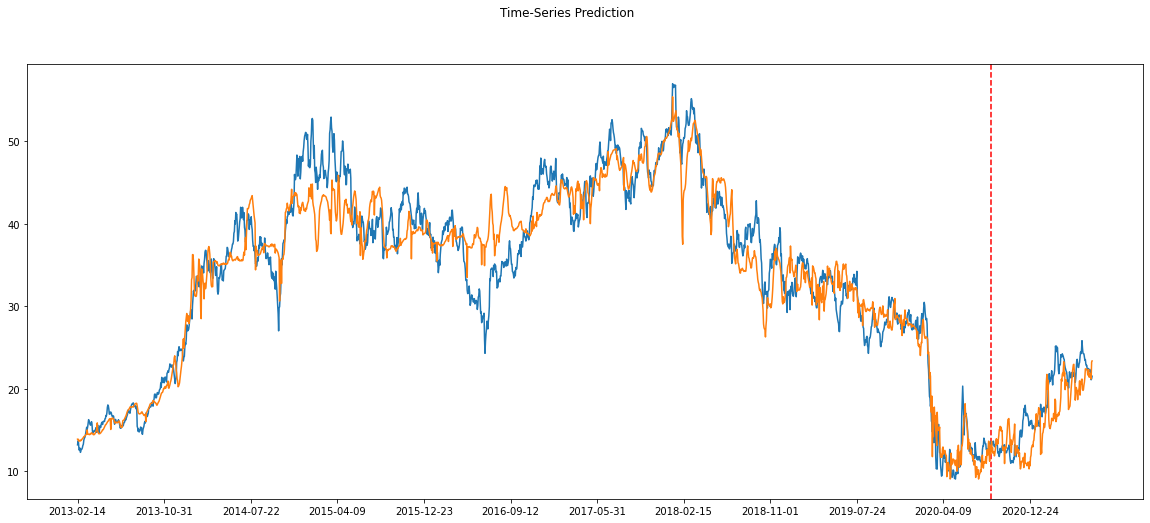

11.095816
Epoch: 0, loss: 0.14999
Epoch: 100, loss: 0.00404
Epoch: 200, loss: 0.00218
Epoch: 300, loss: 0.00203
Epoch: 400, loss: 0.00167
Epoch: 500, loss: 0.00143
Epoch: 600, loss: 0.00148
Epoch: 700, loss: 0.00106
Epoch: 800, loss: 0.00101
Epoch: 900, loss: 0.00105
Epoch: 1000, loss: 0.00108
Epoch: 1100, loss: 0.00085
Epoch: 1200, loss: 0.00074
Epoch: 1300, loss: 0.00111
Epoch: 1400, loss: 0.00097
Epoch: 1500, loss: 0.00065
Epoch: 1600, loss: 0.00085
Epoch: 1700, loss: 0.00060
Epoch: 1800, loss: 0.00107
Epoch: 1900, loss: 0.00055


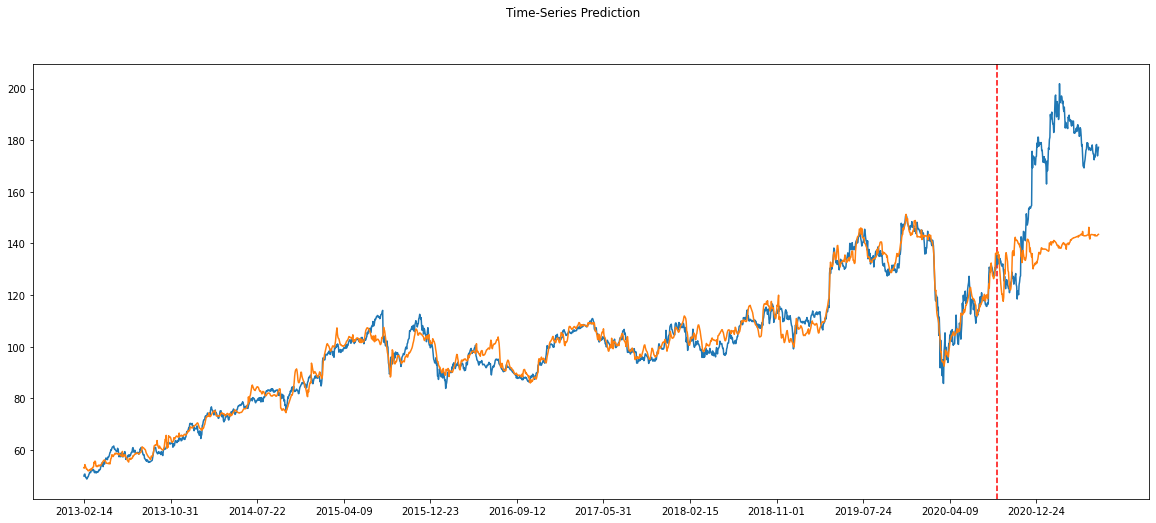

130.82222


In [97]:
for stock in ['PEP', 'AAL', 'DIS']:
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
  np.random.seed(seed)  # Numpy module.
  random.seed(seed)  # Python random module.
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

  sentiments = [
              'pos',
            'neg', 
            'pos - neg', 
            'nrc anger',
            'nrc anticipation', 'nrc disgust', 'nrc fear', 'nrc joy', 'nrc neg',
            'nrc pos', 'nrc sadness', 'nrc surprise', 'nrc trust'
            ]


  features = {
      'seq':  ['volume', 'sp_Close'],
      'tmp': sentiments,
      'tmp2': ['revenue', 'grossProfit', 'netIncome', 'day_delta']
  }

  path = '/content/drive/MyDrive/Team_Daccord/ouput/hypo3/'
  name = f'{stock}_hypo3'
  res, data_y, dates = prepare_df(features)
  trainX, testX, trainY, testY, sc_y, train_size = prepare_data()
  model = run()
  plot()

# Tweets

In [98]:
def prepare_df_tweet(features):
  news = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_news_sentiment.csv', index_col=0).sort_values('date').set_index('date')
  tweet = pd.read_csv('/content/drive/MyDrive/Team_Daccord/data/AAL_tweets.csv').set_index('date')
  sp = pd.read_csv('/content/drive/MyDrive/Team_Daccord/data/SP500.csv')
  sp['Date'] = pd.to_datetime(sp['Date'], format="%m/%d/%y")
  sp = sp.sort_values('Date').set_index('Date')
  sp.columns = ['sp_Open', 'sp_High', 'sp_Low', 'sp_Close'] 
  fin = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_financial.csv', index_col=0)
  a = pd.DataFrame(pd.date_range(start='2009-10-01', end='2021-07-01').strftime("%Y-%m-%d"), columns=['Date']).merge(fin, left_on='Date', right_on='date', how='left').fillna(method='pad')
  b = pd.to_datetime(a['Date'],format="%Y-%m-%d")
  c = pd.to_datetime(a['date'],format="%Y-%m-%d")
  a['day_delta'] = (b - c).apply(lambda x: x.days).values
  a = a.set_index('Date')
  df = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_historical.csv',index_col=0).sort_values('date').set_index('date')
  df = sp.join(df, how='left').join(news, how='left').join(a[list(fin.columns)+['day_delta']], how='left').join(tweet, how='inner')
  df = df.fillna(0)
  dates = df.index[seq_length:].strftime('%Y-%m-%d')

  res = {}
  if features['seq']:
    data_seq = df.loc[:, features['seq']].to_numpy()
    res['seq'] = data_seq
  if features['tmp']:
    data_tmp = df.loc[:, features['tmp']].to_numpy()
    res['tmp'] = data_tmp
  if features['tmp2']:
    data_tmp2 = df.loc[:, features['tmp2']].to_numpy()
    res['tmp2'] = data_tmp2
  data_y = df.loc[:,['adjClose']].to_numpy()
  
  return res, data_y, dates

Epoch: 0, loss: 0.56806
Epoch: 100, loss: 0.03280
Epoch: 200, loss: 0.01226
Epoch: 300, loss: 0.01238
Epoch: 400, loss: 0.00848
Epoch: 500, loss: 0.00729
Epoch: 600, loss: 0.00621
Epoch: 700, loss: 0.00654
Epoch: 800, loss: 0.00526
Epoch: 900, loss: 0.00606
Epoch: 1000, loss: 0.00494
Epoch: 1100, loss: 0.00527
Epoch: 1200, loss: 0.00585
Epoch: 1300, loss: 0.00470
Epoch: 1400, loss: 0.00387
Epoch: 1500, loss: 0.00370
Epoch: 1600, loss: 0.00322
Epoch: 1700, loss: 0.00492
Epoch: 1800, loss: 0.00374
Epoch: 1900, loss: 0.00263


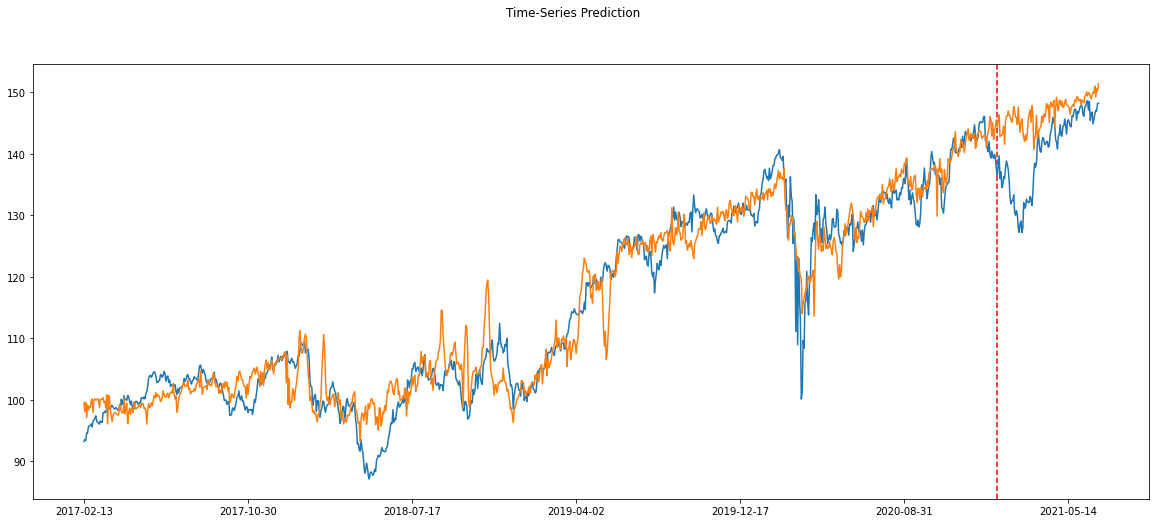

19.715767
Epoch: 0, loss: 0.64810
Epoch: 100, loss: 0.04110
Epoch: 200, loss: 0.00988
Epoch: 300, loss: 0.00834
Epoch: 400, loss: 0.01021
Epoch: 500, loss: 0.00490
Epoch: 600, loss: 0.00378
Epoch: 700, loss: 0.00350
Epoch: 800, loss: 0.00329
Epoch: 900, loss: 0.00289
Epoch: 1000, loss: 0.00245
Epoch: 1100, loss: 0.00229
Epoch: 1200, loss: 0.00195
Epoch: 1300, loss: 0.00182
Epoch: 1400, loss: 0.00154
Epoch: 1500, loss: 0.00809
Epoch: 1600, loss: 0.00330
Epoch: 1700, loss: 0.00306
Epoch: 1800, loss: 0.00329
Epoch: 1900, loss: 0.00413


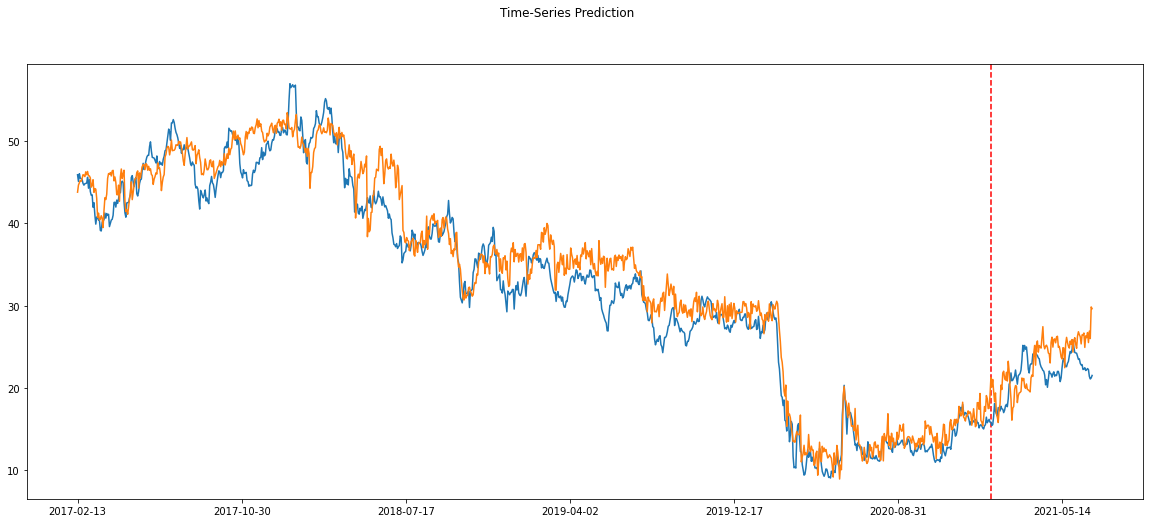

8.51928
Epoch: 0, loss: 0.31196
Epoch: 100, loss: 0.01877
Epoch: 200, loss: 0.00673
Epoch: 300, loss: 0.00356
Epoch: 400, loss: 0.00294
Epoch: 500, loss: 0.00221
Epoch: 600, loss: 0.00202
Epoch: 700, loss: 0.00195
Epoch: 800, loss: 0.00180
Epoch: 900, loss: 0.00169
Epoch: 1000, loss: 0.00215
Epoch: 1100, loss: 0.00147
Epoch: 1200, loss: 0.00141
Epoch: 1300, loss: 0.00130
Epoch: 1400, loss: 0.00123
Epoch: 1500, loss: 0.00130
Epoch: 1600, loss: 0.00120
Epoch: 1700, loss: 0.00116
Epoch: 1800, loss: 0.00106
Epoch: 1900, loss: 0.00106


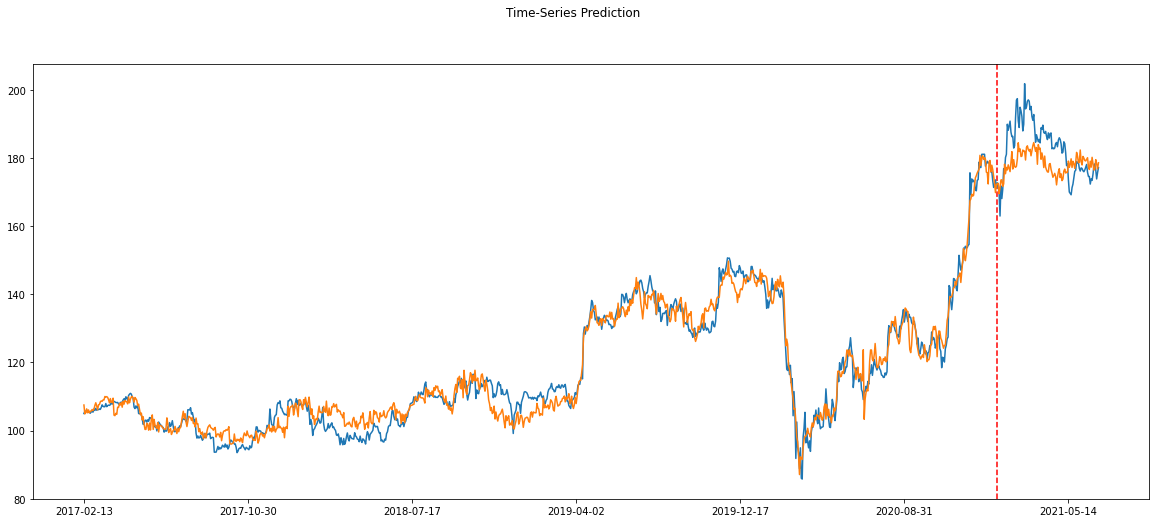

18.872385


In [99]:
for stock in ['PEP', 'AAL', 'DIS']:
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
  np.random.seed(seed)  # Numpy module.
  random.seed(seed)  # Python random module.
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

  sentiments = [
              'pos',
            'neg', 
            'pos - neg', 
            'nrc anger',
            'nrc anticipation', 'nrc disgust', 'nrc fear', 'nrc joy', 'nrc neg',
            'nrc pos', 'nrc sadness', 'nrc surprise', 'nrc trust',
            'pos_tweet', 'neg_tweet',
            'pos - neg_tweet', 'nrc anger_tweet', 'nrc anticipation_tweet',
            'nrc disgust_tweet', 'nrc fear_tweet', 'nrc joy_tweet', 'nrc neg_tweet',
            'nrc pos_tweet', 'nrc sadness_tweet', 'nrc surprise_tweet',
            'nrc trust_tweet', 'num_tweet', 'at_count_tweet', 'tag_count_tweet',
            'reply_sum_tweet', 'retweet_sum_tweet', 'like_sum_tweet'
            ]


  features = {
      'seq':  ['volume', 'sp_Close'],
      'tmp': sentiments,
      'tmp2': ['revenue', 'grossProfit', 'netIncome', 'day_delta']
  }

  path = '/content/drive/MyDrive/Team_Daccord/ouput/tweet/'
  name = f'{stock}_with_tweet'
  res, data_y, dates = prepare_df_tweet(features)
  trainX, testX, trainY, testY, sc_y, train_size = prepare_data()
  model = run()
  plot()

Epoch: 0, loss: 0.28448
Epoch: 100, loss: 0.01373
Epoch: 200, loss: 0.01186
Epoch: 300, loss: 0.01072
Epoch: 400, loss: 0.00975
Epoch: 500, loss: 0.00940
Epoch: 600, loss: 0.00898
Epoch: 700, loss: 0.00909
Epoch: 800, loss: 0.01673
Epoch: 900, loss: 0.01800
Epoch: 1000, loss: 0.01156
Epoch: 1100, loss: 0.01138
Epoch: 1200, loss: 0.01094
Epoch: 1300, loss: 0.00691
Epoch: 1400, loss: 0.00525
Epoch: 1500, loss: 0.00440
Epoch: 1600, loss: 0.00663
Epoch: 1700, loss: 0.00399
Epoch: 1800, loss: 0.00570
Epoch: 1900, loss: 0.00318


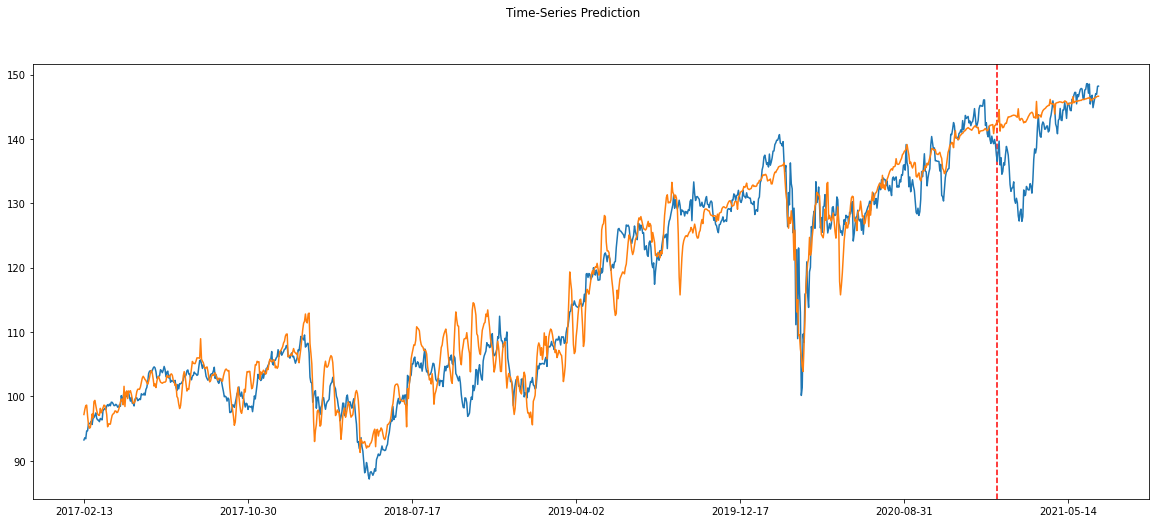

15.403032
Epoch: 0, loss: 0.35324
Epoch: 100, loss: 0.01498
Epoch: 200, loss: 0.00901
Epoch: 300, loss: 0.00651
Epoch: 400, loss: 0.00567
Epoch: 500, loss: 0.00568
Epoch: 600, loss: 0.00429
Epoch: 700, loss: 0.00398
Epoch: 800, loss: 0.00363
Epoch: 900, loss: 0.00348
Epoch: 1000, loss: 0.00315
Epoch: 1100, loss: 0.00713
Epoch: 1200, loss: 0.00325
Epoch: 1300, loss: 0.00294
Epoch: 1400, loss: 0.00233
Epoch: 1500, loss: 0.00230
Epoch: 1600, loss: 0.00307
Epoch: 1700, loss: 0.00253
Epoch: 1800, loss: 0.00219
Epoch: 1900, loss: 0.00208


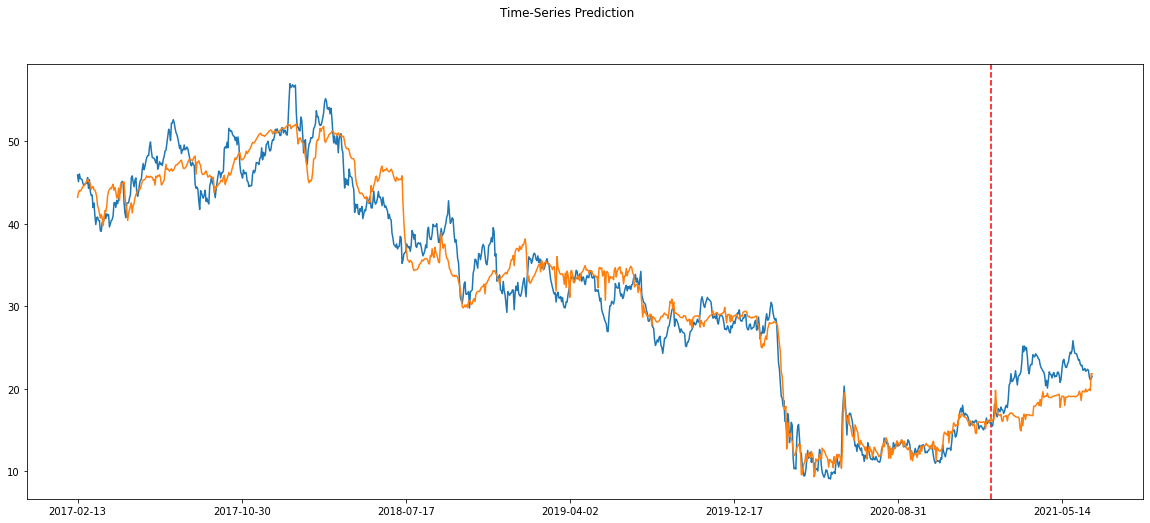

7.858158
Epoch: 0, loss: 0.11676
Epoch: 100, loss: 0.00859
Epoch: 200, loss: 0.00438
Epoch: 300, loss: 0.00291
Epoch: 400, loss: 0.00249
Epoch: 500, loss: 0.00216
Epoch: 600, loss: 0.00177
Epoch: 700, loss: 0.00174
Epoch: 800, loss: 0.00149
Epoch: 900, loss: 0.00149
Epoch: 1000, loss: 0.00135
Epoch: 1100, loss: 0.00128
Epoch: 1200, loss: 0.00119
Epoch: 1300, loss: 0.00119
Epoch: 1400, loss: 0.00117
Epoch: 1500, loss: 0.00102
Epoch: 1600, loss: 0.00083
Epoch: 1700, loss: 0.00076
Epoch: 1800, loss: 0.00077
Epoch: 1900, loss: 0.00069


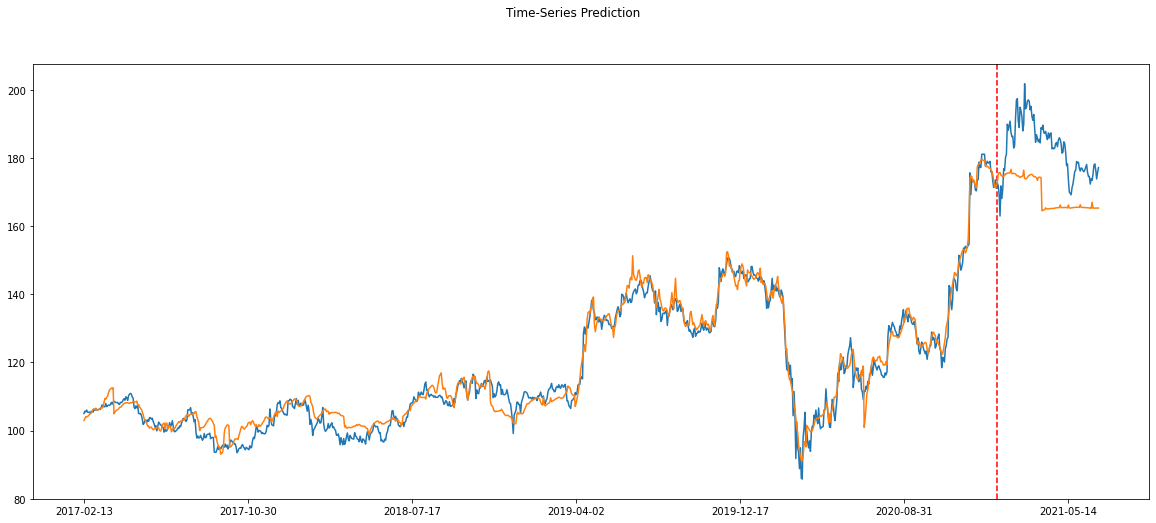

31.82089


In [100]:
for stock in ['PEP', 'AAL', 'DIS']:
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
  np.random.seed(seed)  # Numpy module.
  random.seed(seed)  # Python random module.
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

  sentiments = [
              'pos',
            'neg', 
            'pos - neg', 
            'nrc anger',
            'nrc anticipation', 'nrc disgust', 'nrc fear', 'nrc joy', 'nrc neg',
            'nrc pos', 'nrc sadness', 'nrc surprise', 'nrc trust',
            # 'pos_tweet', 'neg_tweet',
            # 'pos - neg_tweet', 'nrc anger_tweet', 'nrc anticipation_tweet',
            # 'nrc disgust_tweet', 'nrc fear_tweet', 'nrc joy_tweet', 'nrc neg_tweet',
            # 'nrc pos_tweet', 'nrc sadness_tweet', 'nrc surprise_tweet',
            # 'nrc trust_tweet', 'num_tweet', 'at_count_tweet', 'tag_count_tweet',
            # 'reply_sum_tweet', 'retweet_sum_tweet', 'like_sum_tweet'
            ]


  features = {
      'seq':  ['volume', 'sp_Close'],
      'tmp': sentiments,
      'tmp2': ['revenue', 'grossProfit', 'netIncome', 'day_delta']
  }

  path = '/content/drive/MyDrive/Team_Daccord/ouput/tweet/'
  name = f'{stock}_without_tweet'
  res, data_y, dates = prepare_df_tweet(features)
  trainX, testX, trainY, testY, sc_y, train_size = prepare_data()
  model = run()
  plot()

# vs competitor

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.05139
Epoch: 100, loss: 0.00487
Epoch: 200, loss: 0.00462
Epoch: 300, loss: 0.00438
Epoch: 400, loss: 0.00346
Epoch: 500, loss: 0.00332
Epoch: 600, loss: 0.00318
Epoch: 700, loss: 0.00304
Epoch: 800, loss: 0.00291
Epoch: 900, loss: 0.00279
Epoch: 1000, loss: 0.00275
Epoch: 1100, loss: 0.00270
Epoch: 1200, loss: 0.00271
Epoch: 1300, loss: 0.00272
Epoch: 1400, loss: 0.00379
Epoch: 1500, loss: 0.00257
Epoch: 1600, loss: 0.00249
Epoch: 1700, loss: 0.00246
Epoch: 1800, loss: 0.00280
Epoch: 1900, loss: 0.00406


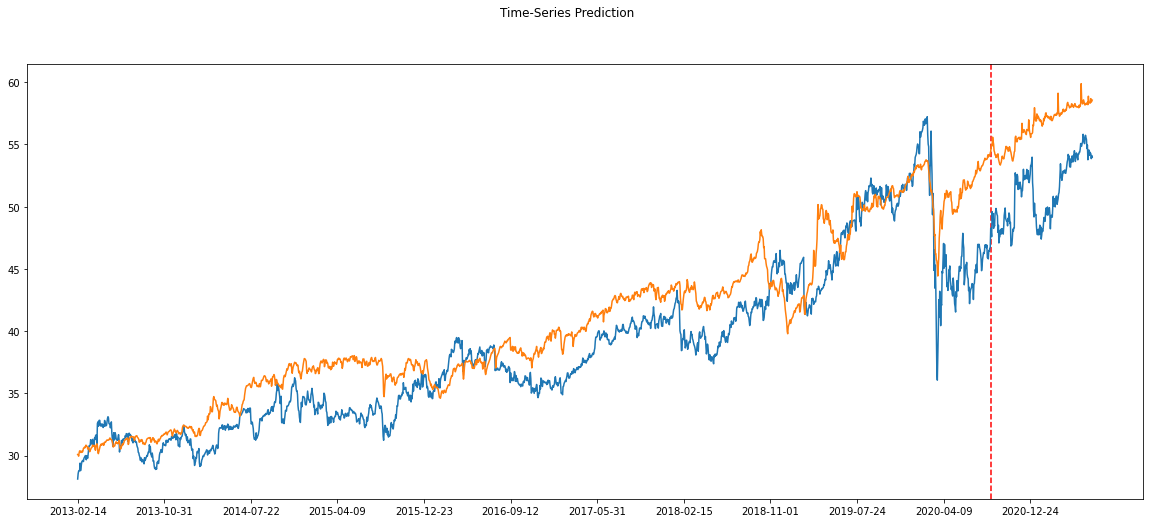

11.698928


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.05727
Epoch: 100, loss: 0.01202
Epoch: 200, loss: 0.00955
Epoch: 300, loss: 0.00892
Epoch: 400, loss: 0.00776
Epoch: 500, loss: 0.00741
Epoch: 600, loss: 0.00798
Epoch: 700, loss: 0.00667
Epoch: 800, loss: 0.00652
Epoch: 900, loss: 0.00622
Epoch: 1000, loss: 0.00577
Epoch: 1100, loss: 0.00543
Epoch: 1200, loss: 0.00526
Epoch: 1300, loss: 0.00895
Epoch: 1400, loss: 0.00623
Epoch: 1500, loss: 0.00509
Epoch: 1600, loss: 0.00591
Epoch: 1700, loss: 0.00552
Epoch: 1800, loss: 0.00469
Epoch: 1900, loss: 0.00473


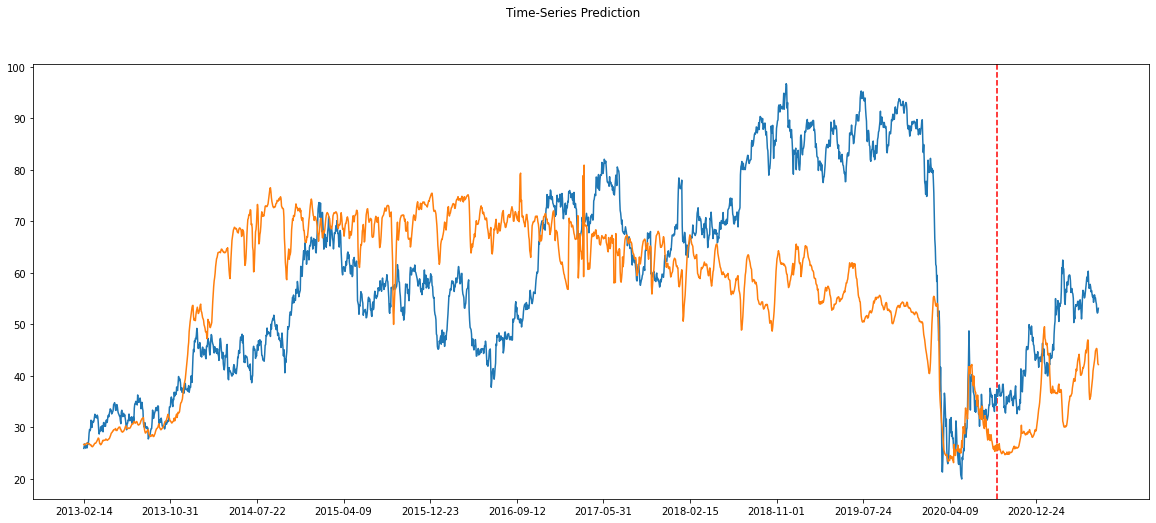

332.13602


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.03925
Epoch: 100, loss: 0.00391
Epoch: 200, loss: 0.00350
Epoch: 300, loss: 0.00264
Epoch: 400, loss: 0.00223
Epoch: 500, loss: 0.00222
Epoch: 600, loss: 0.00197
Epoch: 700, loss: 0.00179
Epoch: 800, loss: 0.00179
Epoch: 900, loss: 0.00149
Epoch: 1000, loss: 0.00126
Epoch: 1100, loss: 0.00118
Epoch: 1200, loss: 0.00110
Epoch: 1300, loss: 0.00105
Epoch: 1400, loss: 0.00101
Epoch: 1500, loss: 0.00094
Epoch: 1600, loss: 0.00084
Epoch: 1700, loss: 0.00076
Epoch: 1800, loss: 0.00075
Epoch: 1900, loss: 0.00071


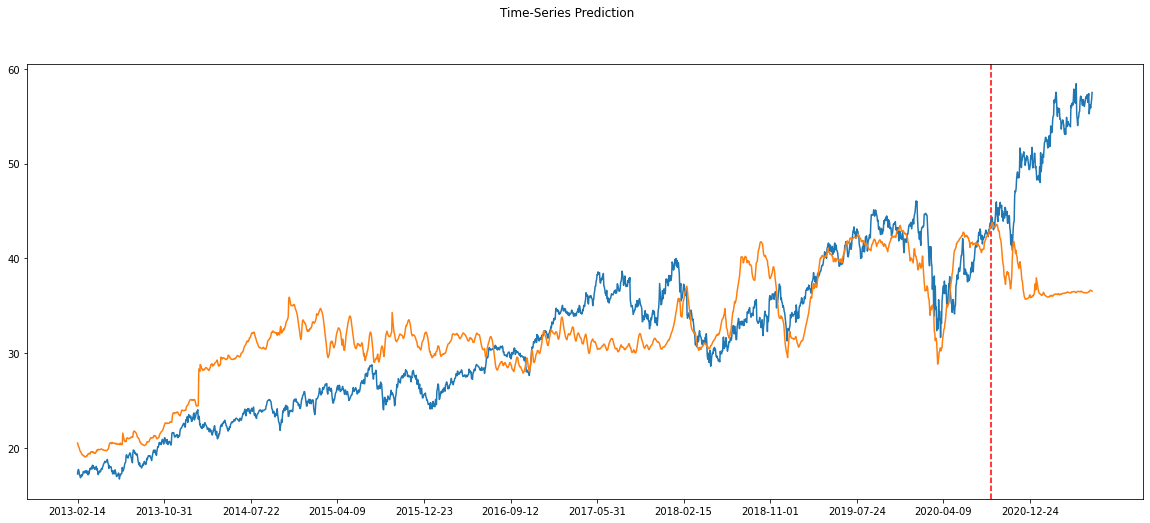

39.922367


In [101]:
def prepare_df_compe(features):
  sp = pd.read_csv('/content/drive/MyDrive/Team_Daccord/data/SP500.csv')
  sp['Date'] = pd.to_datetime(sp['Date'], format="%m/%d/%y")
  sp = sp.sort_values('Date').set_index('Date')
  sp.columns = ['sp_Open', 'sp_High', 'sp_Low', 'sp_Close'] 
  df = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_historical.csv',index_col=0).sort_values('date').set_index('date')
  df = sp.join(df, how='left')
  df = df.fillna(0)

  df = df[df.index > '2013-01-01']
  dates = df.index[seq_length:].strftime('%Y-%m-%d')
  res = {}
  if features['seq']:
    data_seq = df.loc[:, features['seq']].to_numpy()
    res['seq'] = data_seq
  if features['tmp']:
    data_tmp = df.loc[:, features['tmp']].to_numpy()
    res['tmp'] = data_tmp
  if features['tmp2']:
    data_tmp2 = df.loc[:, features['tmp2']].to_numpy()
    res['tmp2'] = data_tmp2
  data_y = df.loc[:,['adjClose']].to_numpy()
  
  return res, data_y, dates
a = ['PEP', 'AAL', 'DIS']
b = ['KO', 'UAL', 'CMCSA']
for i in range(3):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
  np.random.seed(seed)  # Numpy module.
  random.seed(seed)  # Python random module.
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

  sentiments = [
              'pos',
            'neg', 
            'pos - neg', 
            'nrc anger',
            'nrc anticipation', 'nrc disgust', 'nrc fear', 'nrc joy', 'nrc neg',
            'nrc pos', 'nrc sadness', 'nrc surprise', 'nrc trust'
            ]


  features = {
      'seq':  ['volume', 'sp_Close'],
      'tmp': [],
      'tmp2': []
  }
  stock = a[i]
  path = '/content/drive/MyDrive/Team_Daccord/ouput/competition/'
  name = f'{a[i]}_{b[i]}'
  res, data_y, dates = prepare_df(features)
  trainX, testX, trainY, testY, sc_y, train_size = prepare_data()
  model = run()
  stock = b[i]
  res, data_y, dates = prepare_df_compe(features)
  trainX, testX, trainY, testY, sc_y, train_size = prepare_data()
  plot()

#Covid

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.04714
Epoch: 100, loss: 0.00398
Epoch: 200, loss: 0.00340
Epoch: 300, loss: 0.00302
Epoch: 400, loss: 0.00281
Epoch: 500, loss: 0.00276
Epoch: 600, loss: 0.00267
Epoch: 700, loss: 0.00269
Epoch: 800, loss: 0.00262
Epoch: 900, loss: 0.00261
Epoch: 1000, loss: 0.00260
Epoch: 1100, loss: 0.00255
Epoch: 1200, loss: 0.00252
Epoch: 1300, loss: 0.00251
Epoch: 1400, loss: 0.00247
Epoch: 1500, loss: 0.00242
Epoch: 1600, loss: 0.00240
Epoch: 1700, loss: 0.00274
Epoch: 1800, loss: 0.00240
Epoch: 1900, loss: 0.00240


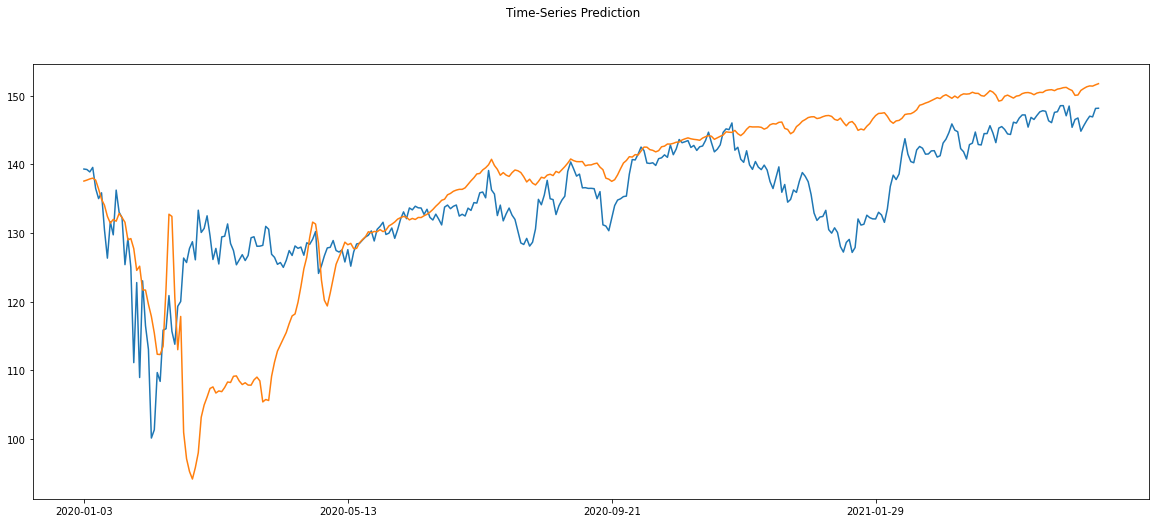

92.944176


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.05047
Epoch: 100, loss: 0.01752
Epoch: 200, loss: 0.01049
Epoch: 300, loss: 0.00962
Epoch: 400, loss: 0.00910
Epoch: 500, loss: 0.00875
Epoch: 600, loss: 0.00791
Epoch: 700, loss: 0.00735
Epoch: 800, loss: 0.00706
Epoch: 900, loss: 0.00765
Epoch: 1000, loss: 0.00715
Epoch: 1100, loss: 0.01019
Epoch: 1200, loss: 0.00626
Epoch: 1300, loss: 0.00572
Epoch: 1400, loss: 0.00519
Epoch: 1500, loss: 0.00622
Epoch: 1600, loss: 0.00642
Epoch: 1700, loss: 0.00558
Epoch: 1800, loss: 0.00573
Epoch: 1900, loss: 0.00479


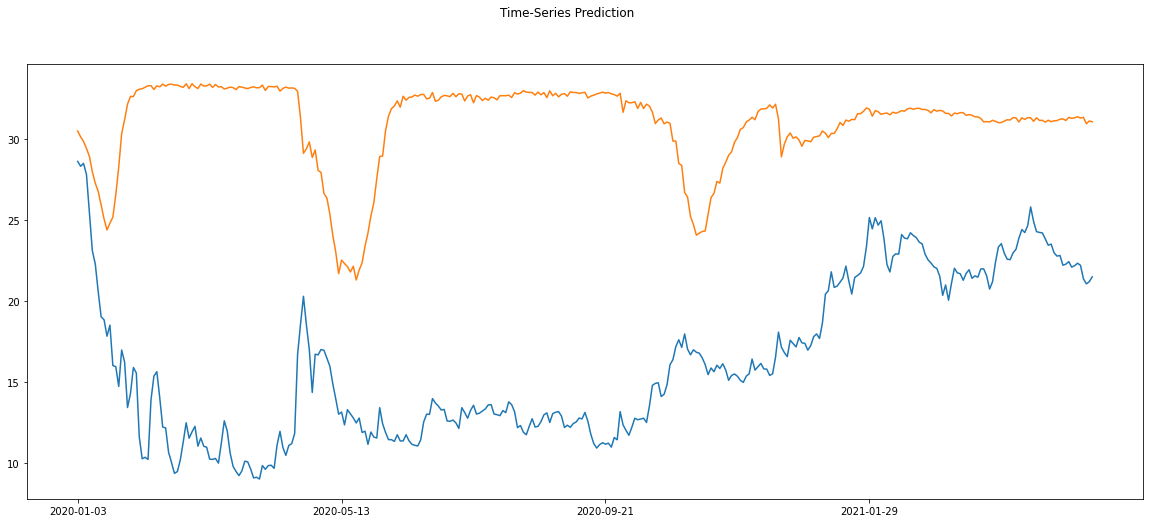

253.01202


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.04179
Epoch: 100, loss: 0.00384
Epoch: 200, loss: 0.00308
Epoch: 300, loss: 0.00210
Epoch: 400, loss: 0.00142
Epoch: 500, loss: 0.00138
Epoch: 600, loss: 0.00133
Epoch: 700, loss: 0.00131
Epoch: 800, loss: 0.00129
Epoch: 900, loss: 0.00127
Epoch: 1000, loss: 0.00125
Epoch: 1100, loss: 0.00123
Epoch: 1200, loss: 0.00119
Epoch: 1300, loss: 0.00113
Epoch: 1400, loss: 0.00116
Epoch: 1500, loss: 0.00113
Epoch: 1600, loss: 0.00108
Epoch: 1700, loss: 0.00123
Epoch: 1800, loss: 0.00115
Epoch: 1900, loss: 0.00113


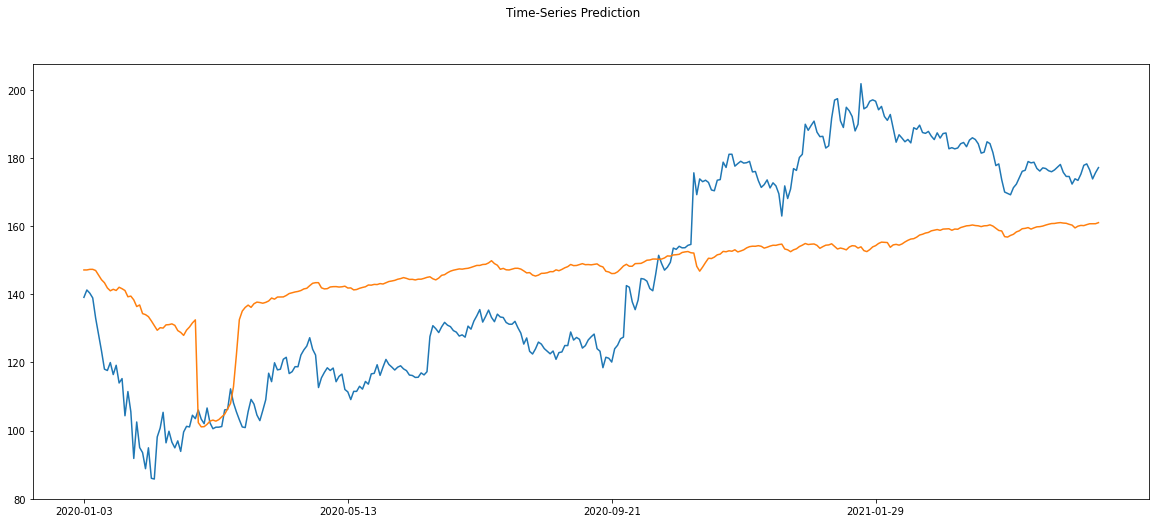

598.6325


In [103]:
def prepare_df_covid(features):
  news = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_news_sentiment.csv', index_col=0).sort_values('date').set_index('date')
  sp = pd.read_csv('/content/drive/MyDrive/Team_Daccord/data/SP500.csv')
  sp['Date'] = pd.to_datetime(sp['Date'], format="%m/%d/%y")
  sp = sp.sort_values('Date').set_index('Date')
  sp.columns = ['sp_Open', 'sp_High', 'sp_Low', 'sp_Close']
  fin = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_financial.csv', index_col=0)
  a = pd.DataFrame(pd.date_range(start='2009-10-01', end='2021-07-01').strftime("%Y-%m-%d"), columns=['Date']).merge(fin, left_on='Date', right_on='date', how='left').fillna(method='pad')
  b = pd.to_datetime(a['Date'],format="%Y-%m-%d")
  c = pd.to_datetime(a['date'],format="%Y-%m-%d")
  a['day_delta'] = (b - c).apply(lambda x: x.days).values
  a = a.set_index('Date')
  df = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_historical.csv',index_col=0).sort_values('date').set_index('date')
  df = sp.join(df, how='left').join(news, how='left').join(a[list(fin.columns)+['day_delta']], how='left')
  df = df.fillna(0)

  df = df[df.index > '2013-01-01']
  split = df.index.get_loc(pd.to_datetime('2020-01-03'))
  dates = df.index[df.index>='2020-01-03'].strftime('%Y-%m-%d')
  res = {}
  if features['seq']:
    data_seq = df.loc[:, features['seq']].to_numpy()
    res['seq'] = data_seq
  if features['tmp']:
    data_tmp = df.loc[:, features['tmp']].to_numpy()
    res['tmp'] = data_tmp
  if features['tmp2']:
    data_tmp2 = df.loc[:, features['tmp2']].to_numpy()
    res['tmp2'] = data_tmp2
  data_y = df.loc[:,['adjClose']].to_numpy()
  
  return res, data_y, dates, split


def prepare_data_covid():
  def sliding_windows(data_seq, seq_length):
      x = []
      for i in range(len(data_seq)-seq_length):
          _x = data_seq[i:(i+seq_length)]
          x.append(_x)
      return np.array(x)

  sc_y = MinMaxScaler()
  y = sc_y.fit_transform(data_y)[seq_length:].reshape(-1, 1)
  train_size = split
  test_size = len(y) - split
  dataY = Variable(torch.Tensor(np.array(y)))
  trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
  testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

  trainX = {}
  testX = {}
  if features['seq']:
    sc_seq = MinMaxScaler()
    x_seq = sliding_windows(sc_seq.fit_transform(res['seq']), seq_length)
    dataX_seq = Variable(torch.Tensor(np.array(x_seq)))
    trainX_seq = Variable(torch.Tensor(np.array(x_seq[0:train_size])))
    trainX['seq'] = trainX_seq
    testX_seq = Variable(torch.Tensor(np.array(x_seq[train_size:len(x_seq)])))
    testX['seq'] = testX_seq
  if features['tmp']:
    sc_tmp = MinMaxScaler()
    x_tmp = sc_tmp.fit_transform(res['tmp'])[seq_length:]
    dataX_tmp = Variable(torch.Tensor(np.array(x_tmp)))
    trainX_tmp = Variable(torch.Tensor(np.array(x_tmp[0:train_size])))
    trainX['tmp'] = trainX_tmp
    testX_tmp = Variable(torch.Tensor(np.array(x_tmp[train_size:len(x_tmp)])))
    testX['tmp'] = testX_tmp
  if features['tmp2']:
    sc_tmp2 = MinMaxScaler()
    x_tmp2 = sc_tmp2.fit_transform(res['tmp2'])[seq_length:]
    dataX_tmp2 = Variable(torch.Tensor(np.array(x_tmp2)))
    trainX_tmp2 = Variable(torch.Tensor(np.array(x_tmp2[0:train_size])))
    trainX['tmp2'] = trainX_tmp2
    testX_tmp2 = Variable(torch.Tensor(np.array(x_tmp2[train_size:len(x_tmp2)])))
    testX['tmp2'] = testX_tmp2

  return trainX, testX, trainY, testY, sc_y, train_size


def plot_covid():
  model.eval()
  all = {}
  for i in trainX.keys():
    all[i] = testX[i]
  
  train_predict = model(all)
  data_predict = train_predict.data.numpy()
  dataY_plot = testY.data.numpy()

  data_predict = sc_y.inverse_transform(data_predict)
  dataY_plot = sc_y.inverse_transform(dataY_plot.reshape(-1, 1))

  plt.figure(figsize=(20,8))
  plt.plot(dataY_plot)
  plt.plot(data_predict)
  plt.xticks(range(0, len(dataY_plot), 90), dates[::90])
  plt.suptitle('Time-Series Prediction')
  plt.show()

  print(MSE(dataY_plot, data_predict))
  pd.DataFrame(np.concatenate([dataY_plot, data_predict],axis=1), columns=['Actual', 'Predicted']).to_csv(f'{path}{name}.csv')

for stock in ['PEP', 'AAL', 'DIS']:
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
  np.random.seed(seed)  # Numpy module.
  random.seed(seed)  # Python random module.
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

  sentiments = [
              'pos',
            'neg', 
            'pos - neg', 
            'nrc anger',
            'nrc anticipation', 'nrc disgust', 'nrc fear', 'nrc joy', 'nrc neg',
            'nrc pos', 'nrc sadness', 'nrc surprise', 'nrc trust'
            ]


  features = {
      'seq':  ['volume', 'sp_Close'],
      'tmp': [],
      'tmp2': []
  }
  path = '/content/drive/MyDrive/Team_Daccord/ouput/covid/'
  name = f'{stock}_covid'
  res, data_y, dates, split = prepare_df_covid(features)
  trainX, testX, trainY, testY, sc_y, train_size = prepare_data_covid()
  model = run()
  plot_covid()

# Quaterly financial effect

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, loss: 0.19579
Epoch: 100, loss: 0.04822
Epoch: 200, loss: 0.04778
Epoch: 300, loss: 0.04713
Epoch: 400, loss: 0.04563
Epoch: 500, loss: 0.04083
Epoch: 600, loss: 0.01969
Epoch: 700, loss: 0.01590
Epoch: 800, loss: 0.01521
Epoch: 900, loss: 0.01434
Epoch: 1000, loss: 0.01381
Epoch: 1100, loss: 0.01348
Epoch: 1200, loss: 0.01322
Epoch: 1300, loss: 0.01301
Epoch: 1400, loss: 0.01283
Epoch: 1500, loss: 0.01265
Epoch: 1600, loss: 0.01247
Epoch: 1700, loss: 0.01229
Epoch: 1800, loss: 0.01209
Epoch: 1900, loss: 0.01190


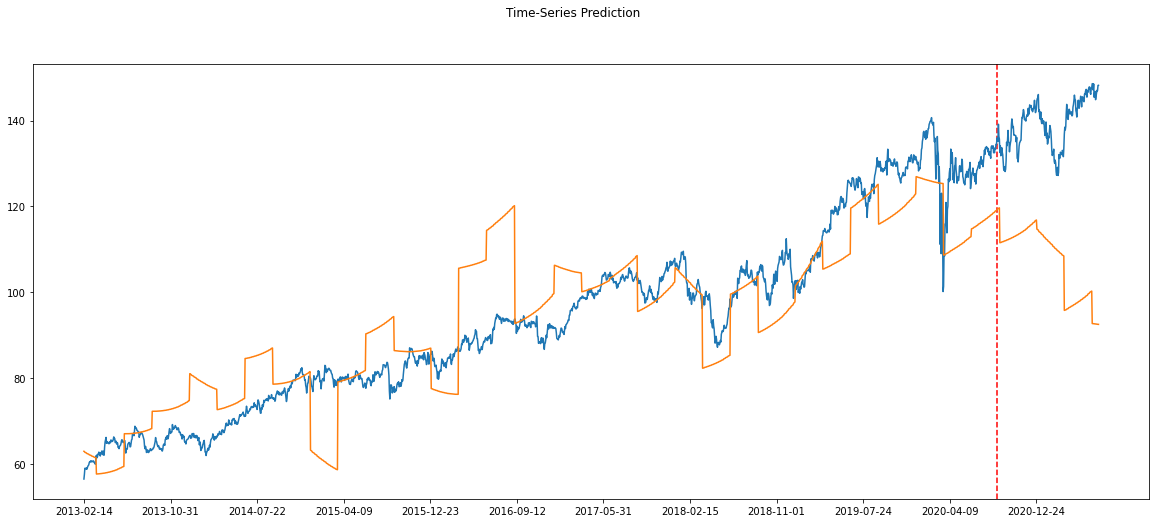

209.52922
Epoch: 0, loss: 0.29943


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 100, loss: 0.04951
Epoch: 200, loss: 0.03751
Epoch: 300, loss: 0.03067
Epoch: 400, loss: 0.03024
Epoch: 500, loss: 0.03004
Epoch: 600, loss: 0.02988
Epoch: 700, loss: 0.02972
Epoch: 800, loss: 0.02953
Epoch: 900, loss: 0.02931
Epoch: 1000, loss: 0.02902
Epoch: 1100, loss: 0.02863
Epoch: 1200, loss: 0.02806
Epoch: 1300, loss: 0.02723
Epoch: 1400, loss: 0.02613
Epoch: 1500, loss: 0.02481
Epoch: 1600, loss: 0.02260
Epoch: 1700, loss: 0.01861
Epoch: 1800, loss: 0.01666
Epoch: 1900, loss: 0.01621


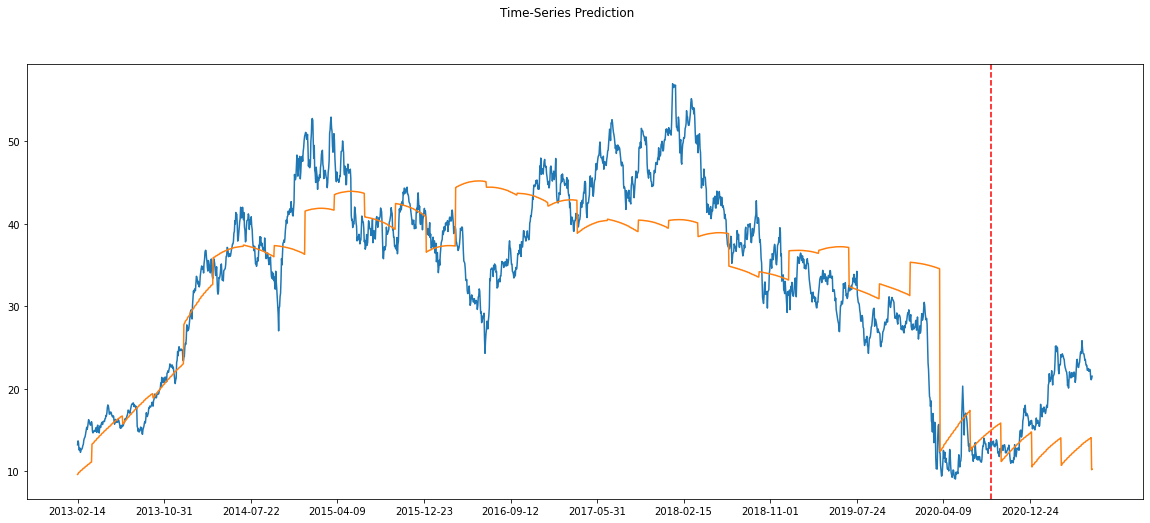

37.897358
Epoch: 0, loss: 0.10986


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 100, loss: 0.01501
Epoch: 200, loss: 0.00759
Epoch: 300, loss: 0.00704
Epoch: 400, loss: 0.00649
Epoch: 500, loss: 0.00583
Epoch: 600, loss: 0.00527
Epoch: 700, loss: 0.00493
Epoch: 800, loss: 0.00477
Epoch: 900, loss: 0.00469
Epoch: 1000, loss: 0.00461
Epoch: 1100, loss: 0.00452
Epoch: 1200, loss: 0.00441
Epoch: 1300, loss: 0.00426
Epoch: 1400, loss: 0.00405
Epoch: 1500, loss: 0.00372
Epoch: 1600, loss: 0.00332
Epoch: 1700, loss: 0.00309
Epoch: 1800, loss: 0.00303
Epoch: 1900, loss: 0.00299


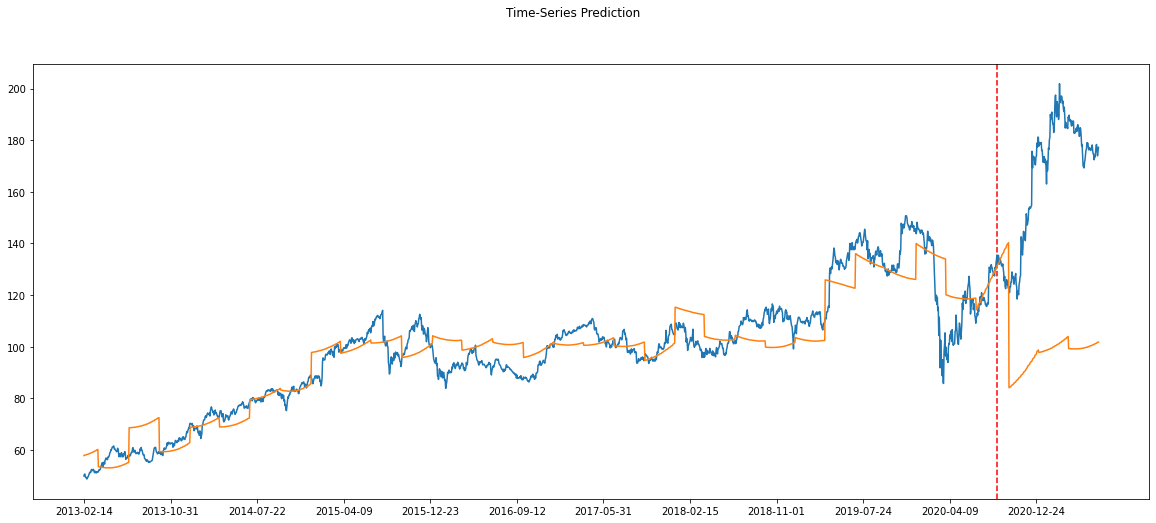

559.41327


In [104]:
for stock in ['PEP', 'AAL', 'DIS']:
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
  np.random.seed(seed)  # Numpy module.
  random.seed(seed)  # Python random module.
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True


  features = {
      'seq':  [],
      'tmp': [],
      'tmp2': ['revenue', 'grossProfit', 'netIncome', 'day_delta']
  }

  path = '/content/drive/MyDrive/Team_Daccord/ouput/quarterly_financial_effect/'
  name = f'{stock}_quarter'
  res, data_y, dates = prepare_df(features)
  trainX, testX, trainY, testY, sc_y, train_size = prepare_data()
  model = run()
  plot()

# Sample data

In [105]:
def prepare_df(features):
  news = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_news_sentiment.csv', index_col=0).sort_values('date').set_index('date')
  tweet = pd.read_csv('/content/drive/MyDrive/Team_Daccord/data/AAL_tweets.csv').set_index('date')
  sp = pd.read_csv('/content/drive/MyDrive/Team_Daccord/data/SP500.csv')
  sp['Date'] = pd.to_datetime(sp['Date'], format="%m/%d/%y")
  sp = sp.sort_values('Date').set_index('Date')
  sp.columns = ['sp_Open', 'sp_High', 'sp_Low', 'sp_Close'] 
  fin = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_financial.csv', index_col=0)
  a = pd.DataFrame(pd.date_range(start='2009-10-01', end='2021-07-01').strftime("%Y-%m-%d"), columns=['Date']).merge(fin, left_on='Date', right_on='date', how='left').fillna(method='pad')
  b = pd.to_datetime(a['Date'],format="%Y-%m-%d")
  c = pd.to_datetime(a['date'],format="%Y-%m-%d")
  a['day_delta'] = (b - c).apply(lambda x: x.days).values
  a = a.set_index('Date')
  df = pd.read_csv(f'/content/drive/MyDrive/Team_Daccord/data/{stock}_historical.csv',index_col=0).sort_values('date').set_index('date')
  df = sp.join(df, how='left').join(news, how='left').join(a[list(fin.columns)+['day_delta']], how='left').join(tweet, how='inner')
  df = df.fillna(0)

  res = {}
  if features['seq']:
    data_seq = df.loc[:, features['seq']].to_numpy()
    res['seq'] = data_seq
  if features['tmp']:
    data_tmp = df.loc[:, features['tmp']].to_numpy()
    res['tmp'] = data_tmp
  if features['tmp2']:
    data_tmp2 = df.loc[:, features['tmp2']].to_numpy()
    res['tmp2'] = data_tmp2
  data_y = df.loc[:,['adjClose']].to_numpy()
  
  return df

In [107]:
sentiments = [
              'pos',
            'neg', 
            'pos - neg', 
            'nrc anger',
            'nrc anticipation', 'nrc disgust', 'nrc fear', 'nrc joy', 'nrc neg',
            'nrc pos', 'nrc sadness', 'nrc surprise', 'nrc trust',
            'pos_tweet', 'neg_tweet',
            'pos - neg_tweet', 'nrc anger_tweet', 'nrc anticipation_tweet',
            'nrc disgust_tweet', 'nrc fear_tweet', 'nrc joy_tweet', 'nrc neg_tweet',
            'nrc pos_tweet', 'nrc sadness_tweet', 'nrc surprise_tweet',
            'nrc trust_tweet', 'num_tweet', 'at_count_tweet', 'tag_count_tweet',
            'reply_sum_tweet', 'retweet_sum_tweet', 'like_sum_tweet'
            ]


features = {
    'seq':  ['volume', 'sp_Close'],
    'tmp': sentiments,
    'tmp2': ['revenue', 'grossProfit', 'netIncome', 'day_delta']
}

df = prepare_df(features)
df.to_csv('/content/drive/MyDrive/Team_Daccord/ouput/sample_data.csv')
df

,sp_Open,sp_High,sp_Low,sp_Close,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime,news,pos,neg,pos - neg,nrc anger,nrc anticipation,nrc disgust,nrc fear,nrc joy,nrc neg,nrc pos,nrc sadness,nrc surprise,nrc trust,date,revenue,grossProfit,netIncome,day_delta,pos_tweet,neg_tweet,pos - neg_tweet,nrc anger_tweet,nrc anticipation_tweet,nrc disgust_tweet,nrc fear_tweet,nrc joy_tweet,nrc neg_tweet,nrc pos_tweet,nrc sadness_tweet,nrc surprise_tweet,nrc trust_tweet,num_tweet,at_count_tweet,tag_count_tweet,reply_sum_tweet,retweet_sum_tweet,like_sum_tweet
2016-12-29,2249.50,2254.51,2244.56,2249.26,104.230003,104.769997,103.870003,104.559998,100.128761,5896800.0,5896800.0,0.32999,0.317,104.40000,"December 29, 16",0.00317,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-09-30,1.314200e+10,5.837000e+09,1.771000e+09,90.0,0.000000,0.000000,0.000000,0.022624,0.121267,0.018100,0.026244,0.064253,0.038914,0.110407,0.026244,0.023529,0.136652,106,109,41,79,31,353
2016-12-30,2251.61,2253.58,2233.62,2238.83,104.570000,105.000000,103.959999,104.220001,99.803192,6983300.0,6983300.0,-0.35000,-0.335,104.39333,"December 30, 16",-0.00335,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-09-30,1.314200e+10,5.837000e+09,1.771000e+09,91.0,0.000000,0.000000,0.000000,0.016529,0.077686,0.010862,0.022904,0.070366,0.039669,0.120661,0.024557,0.027155,0.069421,446,799,158,278,293,2104
2017-01-03,2251.57,2263.88,2245.13,2257.83,105.300003,106.900002,105.209999,106.080002,101.584358,8884300.0,8884300.0,0.78000,0.741,106.06333,"January 03, 17",0.00741,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-12-31,1.478400e+10,6.378000e+09,2.479000e+09,3.0,0.000000,0.000000,0.000000,0.019213,0.051546,0.014761,0.025070,0.043580,0.050375,0.094189,0.029053,0.019681,0.064433,484,648,154,447,1120,3201
2017-01-04,2261.60,2272.82,2261.60,2270.75,106.639999,107.500000,106.250000,107.440002,102.886719,8322000.0,8322000.0,0.80000,0.750,107.06333,"January 04, 17",0.00750,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-12-31,1.478400e+10,6.378000e+09,2.479000e+09,4.0,0.000000,0.000000,0.000000,0.016015,0.048317,0.013572,0.026873,0.048046,0.047231,0.094463,0.025787,0.018187,0.055917,411,492,165,252,305,1389
2017-01-05,2268.18,2271.50,2260.45,2269.00,107.169998,107.620003,106.790001,107.379997,102.829262,6303000.0,6303000.0,0.21000,0.196,107.26333,"January 05, 17",0.00196,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-12-31,1.478400e+10,6.378000e+09,2.479000e+09,5.0,0.000000,0.000000,0.000000,0.022721,0.055867,0.016306,0.026196,0.048115,0.044373,0.100241,0.024592,0.024860,0.063619,418,495,201,420,419,2446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-25,4274.45,4286.12,4271.16,4280.70,178.830000,179.090000,177.490000,178.350000,178.350000,7474251.0,7474251.0,-0.48000,-0.268,178.31000,"June 25, 21",-0.00268,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-03,1.561300e+10,5.831000e+09,9.010000e+08,83.0,0.051173,0.054016,-0.002843,0.022270,0.041459,0.013978,0.025586,0.032694,0.054016,0.076048,0.027482,0.023217,0.042407,349,615,83,412,321,9250
2021-06-28,4284.90,4292.14,4274.67,4290.61,178.500000,178.660000,174.990000,176.570000,176.570000,9299869.0,9299869.0,-1.93000,-1.081,176.74000,"June 28, 21",-0.01081,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-03,1.561300e+10,5.831000e+09,9.010000e+08,86.0,0.054858,0.049699,0.005159,0.016853,0.048495,0.013758,0.027343,0.038693,0.049527,0.085813,0.029579,0.019433,0.054686,433,722,182,394,226,3008
2021-06-29,4293.21,4300.52,4287.04,4291.80,176.640000,177.020000,173.800000,173.930000,173.930000,9548617.0,9548617.0,-2.71000,-1.534,174.91667,"June 29, 21",-0.01534,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-03,1.561300e+10,5.831000e+